In [59]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot
import seaborn

In [60]:
FIG_SIZE = (6, 3)
FIG_SIZE_WIDE = (9, 3)

PALETTE = seaborn.color_palette()
DATE_RANGE = pd.to_datetime('2019-11-01'), pd.to_datetime('2022-08-31')

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
# matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

SAVEFIG = False

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

## Load Data

In [61]:
df_repo = (
    pd.read_csv('../data/workflow_files.csv.gz')
    .assign(date=lambda d: pd.to_datetime(d.date))
)

In [62]:
df_steps = (
    pd.read_csv('../data/steps.csv.gz')
)

## Some numbers...

In [63]:
print('There are', df_repo.repository.nunique(), 'repositories')
print('There are', df_repo.workflow.nunique(), 'distinct workflows')
print('There are', len(df_steps), 'unique steps')

There are 22758 repositories
There are 203552 distinct workflows
There are 2319902 unique steps


## Number of repositories, workflows and steps through time

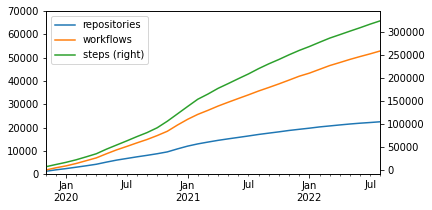

In [110]:
fig, ax = matplotlib.pyplot.subplots()

temp = pd.concat([
    df_repo
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(repositories=('repository', 'nunique'))
    ,
    df_repo
    .groupby(['repository', 'date'], sort=False, as_index=False)
    .agg(workflows=('filename', 'nunique'))
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(workflows=('workflows', 'sum'))
    ,
    df_steps
    .groupby('workflow', as_index=False, sort=False)
    .agg(steps=('name', 'count'))
    .merge(
        df_repo[['repository', 'date', 'workflow']],
        how='right',
        on='workflow',
    )
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(steps=('steps', 'sum'))
], axis=1)

temp[['repositories', 'workflows']].plot(ax=ax)
temp[['steps']].plot(ax=ax, secondary_y=True)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel=None,
    ylim=(0, 70000),
)

savefig(fig, 'overview_repositories')

In [91]:
temp.iloc[-1]

repositories     22756.0
workflows        53801.0
steps           330186.0
Name: 2022-09-30 00:00:00, dtype: float64

## Proportion of repositories and steps relying on an Action

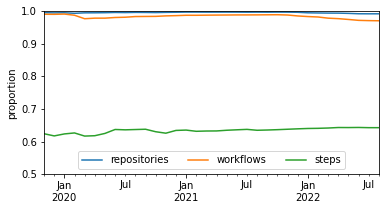

In [99]:
fig, ax = matplotlib.pyplot.subplots()

_ = (
    df_steps
    [['workflow', 'uses']]
    [lambda d: ~d.uses.isnull()]
    [lambda d: ~d.uses.str.startswith(('docker://', './', 'http'))]
    [lambda d: d.uses.str.count('/') == 1]
    .groupby('workflow', as_index=False, sort=False)
    .agg(steps=('uses', 'count'))
    .merge(
        df_repo[['repository', 'date', 'workflow']],
        how='left',
        on='workflow',
    )
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(repositories=('repository', 'nunique'), workflows=('workflow', 'count'), steps=('steps', 'sum'))
    .assign(repositories=lambda d: d.repositories / temp.repositories)
    .assign(workflows=lambda d: d.workflows / temp.workflows)
    .assign(steps=lambda d: d.steps / temp.steps)
)

_.plot(ax=ax)

ax.legend(loc='lower center', ncol=3)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='proportion',
    ylim=(0.5, 1)
)

savefig(fig, 'overview_proportion_actions')

In [101]:
display(_.describe().T)
display(_.iloc[-1])

,count,mean,std,min,25%,50%,75%,max
repositories,35.0,0.995252,0.001699,0.991563,0.994480,0.995561,0.996784,0.997013
workflows,35.0,0.983081,0.006297,0.969090,0.978441,0.985187,0.988049,0.990996
steps,35.0,0.634102,0.007659,0.616878,0.630889,0.636060,0.639646,0.643317


repositories    0.991563
workflows       0.969090
steps           0.643159
Name: 2022-09-30 00:00:00, dtype: float64

## Number of distinct Actions relied on

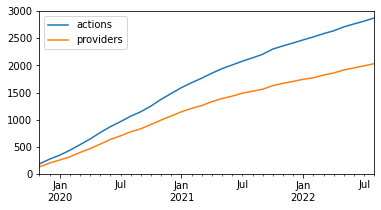

In [124]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_steps
    [['workflow', 'uses']]
    [lambda d: ~d.uses.isnull()]
    [lambda d: ~d.uses.str.startswith(('docker://', './', 'http'))]
    [lambda d: d.uses.str.count('/') == 1]
    .assign(action=lambda d: d.uses.str.split('@', n=1).str[0].str.lower())
    .assign(provider=lambda d: d.uses.str.split('/', n=1).str[0].str.lower())
    .merge(
        df_repo[['repository', 'date', 'workflow']],
        how='left',
        on='workflow',
    )
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(actions=('action', 'nunique'), providers=('provider', 'nunique'))
)

temp[['actions', 'providers']].plot(ax=ax)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylim=(0, 3000),
)

savefig(fig, 'overview_distinct_actions')

In [122]:
display(temp.describe().T)
display(temp.iloc[-1])

,count,mean,std,min,25%,50%,75%,max
actions,35.0,1716.171429,850.813538,189.0,1018.0,1859.0,2442.5,2930.0


actions    2930
Name: 2022-09-30 00:00:00, dtype: int64

GitHub distributes the most widely used Actions, such as `checkout` or the various `setup-*`. We made an analysis in the `Technical lag` notebook to quantify the extent to which repositories and steps rely on Actions provided by GitHub. Refer to this notebook for more details. 

## Distribution of the number of Actions used in a repository

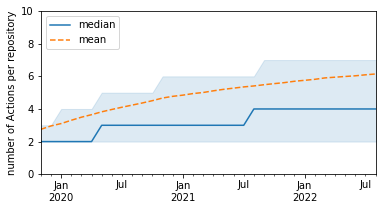

In [125]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_steps
    [['workflow', 'uses']]
    [lambda d: ~d.uses.isnull()]
    [lambda d: ~d.uses.str.startswith(('docker://', './', 'http'))]
    [lambda d: d.uses.str.count('/') == 1]
    .assign(action=lambda d: d.uses.str.split('@', n=1).str[0].str.lower())
    .groupby('workflow', as_index=False, sort=False)
    .agg(actions=('action', 'nunique'))
    .merge(
        df_repo[['repository', 'date', 'workflow']],
        how='left',
        on='workflow',
    )
    .groupby(['date', 'repository'], as_index=False, sort=False)
    .agg(actions=('actions', 'sum'))
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(
        mean=('actions', 'mean'),
        median=('actions', 'median'),
        p25=('actions', lambda s: s.quantile(0.25)),
        p75=('actions', lambda s: s.quantile(0.75)),
    )
)

temp[['median', 'mean']].plot(ax=ax, style={'mean': '--'})
ax.fill_between(temp.index, temp.p25, temp.p75, color=PALETTE[0], alpha=0.15)
ax.legend(loc='upper left')

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='number of Actions per repository',
    ylim=(0, 10),
)

savefig(fig, 'overview_distribution_actions')

In [116]:
temp.describe().T

,count,mean,std,min,25%,50%,75%,max
mean,35.0,4.889171,1.010968,2.751422,4.171721,5.112408,5.728004,6.185605
median,35.0,3.228571,0.731063,2.000000,3.000000,3.000000,4.000000,4.000000
p25,35.0,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000
p75,35.0,5.800000,1.231928,3.000000,5.000000,6.000000,7.000000,7.000000
